# Librerias

In [1]:
import os

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import xgboost as xgb
import lightgbm as lgb

In [2]:
import pickle

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import shap
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [4]:
# if pd.__version__ != "2.2.1":
#     os.system("pip install pandas==2.2.1")

In [5]:
pd.__version__ 

'2.2.1'

# Funciones

In [6]:
def recuperar_fechas(df, dfo):
    '''
    Recupera las fechas originales y las añade al DataFrame.
    '''
    # Obtener las combinaciones únicas de 'yearweek' y 'date' del DataFrame original
    unicos = dfo[["yearweek", "date"]].drop_duplicates()
    
    # Eliminar la columna 'date' del DataFrame (df)
    df.drop(["date"], inplace=True, axis=1)
    
    # Hacer un merge  del DataFrame (df) con el DataFrame de fechas únicas (unicos).
    df = pd.merge(df, unicos, on=["yearweek"], how="left")
    
    return df
  

In [7]:
def load_data(TRAIN_CSV_PATH):
    '''
    Carga el DataFrame (df).
    '''
    # Lee el archivo CSV en un DataFrame
    df = pd.read_csv(TRAIN_CSV_PATH)
    
    # Convierte la columna "date" a formato de fecha
    df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

    # Extrae el mes, trimestre, año y semana de la columna de fecha
    df['month'] = df['date'].dt.month.astype("uint8")
    df['quarter'] = df['date'].dt.quarter.astype("uint16")
    df['year'] = df['date'].dt.isocalendar().year.astype("uint16")
    df["week"] = df['date'].dt.isocalendar().week.astype("uint16")

    # Convierte varias columnas a tipos de datos más eficientes
    df["item"] = df["item"].astype("uint16")
    df["category"] = df["category"].astype("uint8")
    df["department"] = df["department"].astype("uint8")
    df["store_code"] = df["store_code"].astype("uint8")
    df["region"] = df["region"].astype("uint8")
    df["event"] = df["event"].astype("uint8")
    df["event2"] = df["event2"].astype("uint8")

    # Convierte la columna "Cantidad" a tipo float64
    df["Cantidad"] = df["Cantidad"].astype("float64")
  
    # Crea un DataFrame sin registros con ventas iguales a 0
    df2 = df[df["Cantidad"] != 0]

    # Define el primer día de venta de cada producto para luego filtrar el dataset
    df_fechas_agregadas_por_ventas = df2.groupby(["id"]).agg(
        fecha_ult_venta = ('yearweek', 'max'),
        fecha_prim_venta = ('yearweek', 'min')
    ).reset_index()
    
    # Añade el primer día de venta por ID al DataFrame principal
    df = pd.merge(df, df_fechas_agregadas_por_ventas[["id", "fecha_prim_venta"]], how="left", on=["id"]) 
    
    # Elimina los registros de ventas antes del primer día de venta
    df = df[df["yearweek"] >= df["fecha_prim_venta"]] 
    df.drop(columns=["fecha_prim_venta"], inplace=True)
    
    # Reinicia el índice y ordena el DataFrame por semana y id
    df.reset_index(drop=True, inplace=True)
    df.sort_values(["yearweek", "id"], ascending=True, inplace=True)
    
    # Lista de productos sin ventas en el último año
    sinventas_ultimoano = df_fechas_agregadas_por_ventas[df_fechas_agregadas_por_ventas["fecha_ult_venta"] < 201517]["id"].to_list()
    
    # Filtra los productos que aún tienen ventas
    df_prod_cont = df.loc[~df['id'].isin(sinventas_ultimoano)]
    
    # Filtra los datos desde la semana 201316 en adelante
    semana = 201316
    df_final = df_prod_cont.loc[df_prod_cont["yearweek"] > semana]
    
    # Reinicia el índice y ordena el DataFrame final
    df_final.reset_index(drop=True, inplace=True)
    df_final.sort_values(["yearweek", "id"], ascending=True, inplace=True)
    
    # Retorna los DataFrames
    return df, df_final


def append_new_date(df, new_date, dffo):
    '''
    Añade una nueva semana-año al DataFrame histórico.
    
    '''
    # Filtra los datos del DataFrame a predecir (dffo) para obtener las filas correspondientes a la nueva fecha (new_date)
    new_data = dffo[dffo["yearweek"] == new_date]
    
    # Concatenar el nuevo conjunto de datos (new_data) con el DataFrame histórico (df)
    df = pd.concat([df, new_data])
    
    # Ordenar el DataFrame resultante por 'id' y 'yearweek' de forma ascendente
    df.sort_values(["id", "yearweek"], ascending=True, inplace=True)
    
    # Devolver el DataFrame actualizado
    return df


def build_ts_features(df):
    '''
    Genera características de series temporales.
    '''
    
    # Crea una copia del DataFrame original
    df_copy = df.copy(deep=True)
   
    # Define los shift (lags) que se usarán para crear las características
    lags = [1, 4, 9]
    
    # Crea características de shift (lags) de cantidades vendidas
    for lag in lags:
        df_copy["UID_sales_lag_" + str(lag)] = df_copy.groupby(["id"])["Cantidad"].shift(lag).astype("float64")
    
    # Crea características de medias móviles con diferentes ventanas de tiempo 4 ,8 y 12 semanas.
    for lag in lags:
        df_copy['UID_MA_lag_{}_win_{}'.format(lag, 4)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=4).mean()).astype(np.float64)
    for lag in lags:
        df_copy['UID_MA_lag_{}_win_{}'.format(lag, 8)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=8).mean()).astype(np.float64)
    for lag in lags:
        df_copy['UID_MA_lag_{}_win_{}'.format(lag, 12)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=12).mean()).astype(np.float64)
    
    # Crea características de máximos móviles con diferentes ventanas de tiempo 4 ,8 y 12 semanas.
    for lag in lags:
        df_copy['UID_Mmax_lag_{}_win_{}'.format(lag, 4)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=4).max()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mmax_lag_{}_win_{}'.format(lag, 8)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=8).max()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mmax_lag_{}_win_{}'.format(lag, 12)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=12).max()).astype(np.float64)
    
    # Crea características de desviaciones estándar móviles con diferentes ventanas de tiempo 4 ,8 y 12 semanas.
    for lag in lags:
        df_copy['UID_Mstd_lag_{}_win_{}'.format(lag, 4)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=4).std()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mstd_lag_{}_win_{}'.format(lag, 8)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=8).std()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mstd_lag_{}_win_{}'.format(lag, 12)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=12).std()).astype(np.float64) 

    # Define las columnas a eliminar
    COLUMNS_TO_DROP = ["date", "event"]

    # Elimina las columnas especificadas
    df_copy.drop(COLUMNS_TO_DROP, inplace=True, axis=1)
    
    # Ordena el DataFrame original por id y semana del año
    df.sort_values(["id", "yearweek"], ascending=True, inplace=True)
    
    # Establece el índice del DataFrame copiado a "id"
    df_copy.set_index("id", inplace=True)

    # Devuelve el DataFrame con las nuevas características
    return df_copy


def split_train_new_pred(df):
    '''
    Divide los datos para entrenamiento, validación y prueba.
    '''
    
    # Definir los índices de los datos de entrenamiento, validación y prueba basados en 'yearweek'
    train_index = sorted(list(df["yearweek"].unique()))[:-5]  # Todos los períodos excepto los últimos 5
    valida_index = sorted(list(df["yearweek"].unique()))[-5:-1]  # Los 4 períodos antes del último
    test_index = [sorted(list(df["yearweek"].unique()))[-1]]  # El último período

    # Crear los conjuntos de entrenamiento
    X_train = df[df["yearweek"].isin(train_index)].drop(["Cantidad"], axis=1)  
    Y_train = df[df["yearweek"].isin(train_index)]["Cantidad"]  

    # Crear los conjuntos de validación
    X_valida = df[df["yearweek"].isin(valida_index)].drop(["Cantidad"], axis=1)  
    Y_valida = df[df["yearweek"].isin(valida_index)]["Cantidad"]  

    # Crear los conjuntos de prueba
    X_test = df[df["yearweek"].isin(test_index)].drop(["Cantidad"], axis=1)
    Y_test = df[df["yearweek"].isin(test_index)]["Cantidad"]  
    
    
    return X_train, Y_train, X_valida, Y_valida, X_test, Y_test


def train_model(X_train, Y_train, X_valida, Y_valida):
    '''
    Inicializa, entrena y devuelve un modelo LightGBM Regressor entrenado.
    '''
    # Inicializar el modelo de regresión LGBM (LightGBM)
    model = lgb.LGBMRegressor(
        objective='rmse',  # Especifica la función objetivo como RMSE (Root Mean Squared Error)
        early_stopping_rounds=10,  # Detiene el entrenamiento temprano si no hay mejora en 10 rondas
        n_estimators=1000,  # Número máximo de árboles de decisión
        learning_rate=0.005  # Tasa de aprendizaje
    )

    # Entrenar el modelo utilizando los datos de entrenamiento
    model.fit(
        X_train, Y_train,  # Datos de entrenamiento y sus etiquetas
        eval_set=[(X_valida, Y_valida)],  # Conjunto de validación para evaluar el modelo durante el entrenamiento
        eval_metric='rmse'  # Métrica de evaluación (RMSE)
    )
        
    return model

def get_1_step_prediction(model, X_test, new_date):
    '''
    Realiza una predicción de un paso hacia adelante y convierte las predicciones en un DataFrame de pandas.
    '''
    # Realizar la predicción usando el modelo entrenado
    y_pred = model.predict(X_test).astype("float64")
    
    # Crear una copia profunda del DataFrame de prueba para mantener los datos originales
    y_pred_df = X_test.copy(deep=True)
    
    # Agregar las predicciones al DataFrame copiado
    y_pred_df["Cantidad"] = y_pred
    
    # Asignar la nueva fecha (año-semana) a cada fila predicha
    y_pred_df["yearweek"] = new_date

    # Retornar el DataFrame con las predicciones
    return y_pred_df



def get_n_step_prediction(dfh, idxf, dffo, dfo, verbose=True):
    '''
    Realiza una predicción de varios pasos hacia adelante.
    '''
    # Inicializar la lista de resultados
    resultados = []

    # Iterar sobre las nuevas fechas
    for new_date in idxf:
        if verbose: print(f"Trabajando con la fecha {new_date}.")
        
        # Añadir una nueva fecha al dataframe histórico
        dfh = append_new_date(df=dfh, new_date=new_date, dffo=dffo)
        
        # Construir características de series temporales
        dfhf = build_ts_features(df=dfh)
        
        # Dividir los datos entre entrenamiento y predicción
        X_train, Y_train, X_valida, Y_valida, X_test, Y_test = split_train_new_pred(dfhf)
        columnas=X_test.columns

        # Entrenar el modelo y obtener predicciones, el modelo solo se entrena cuando recibe los datos historicos.
        if new_date == 201617:
            model = train_model(X_train=X_train, Y_train=Y_train, X_valida=X_valida, Y_valida=Y_valida)
        y_pred_df = get_1_step_prediction(model=model, X_test=X_test, new_date=new_date)

        # Guardamos la importancia de las variables
        feature_importance = model.feature_importances_

        # Añadir las nuevas predicciones al dataframe histórico
        y_pred_df = y_pred_df.reset_index().rename(columns={'index': 'id'})
        y_pred_df = y_pred_df.reindex(columns=dfh.columns)
        y_pred_df = recuperar_fechas(y_pred_df, dfo) # se aplica la funcion para reincorporar la columna 'date' al dataframe.
        y_pred_df = y_pred_df.reindex(columns=dfh.columns)
        dfh = dfh[dfh["yearweek"] != new_date]
        dfh.reset_index(drop=True, inplace=True)
        dfh = pd.concat([dfh, y_pred_df])
        dfh.sort_values(["id", "yearweek"], ascending=True, inplace=True)
        dfh.reset_index(drop=True, inplace=True)

        # Calcular el RMSE para el conjunto de entrenamiento y validación
        Y_train_predict = model.predict(X_train).astype("float64")
        Y_valida_predict = model.predict(X_valida).astype("float64")

        rmse_train = np.sqrt(mean_squared_error(y_true=Y_train, y_pred=Y_train_predict))
        rmse_valida = np.sqrt(mean_squared_error(y_true=Y_valida, y_pred=Y_valida_predict))

        rmse_train = str(round(rmse_train, 3)).replace(".", "_")
        rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

        # Calcular las prediccion de validación y generar un dataframe con los resultados cuando el modelo se entrena con los datos historicos.
        if new_date == 201617:
            Y_valida_predict = model.predict(X_valida).astype("float64")
            y_val_df = X_valida.copy(deep=True)
            y_val_df["Cantidad"] = Y_valida_predict
            y_val_df = y_val_df.reset_index().rename(columns={'index': 'id'})
            y_val_df = y_val_df.reindex(columns=dfh.columns)
            y_val_df = recuperar_fechas(y_val_df, dfo)
            y_val_df = y_val_df.reindex(columns=dfh.columns)
            a = (feature_importance, rmse_train, rmse_valida)
            resultados.append(a)
            res = pd.DataFrame(resultados, columns=["Importancia", "Train RMSE", "Validation RMSE"])

        if verbose: print()

    return dfh, y_val_df, res,columnas

def plot_predictions(dfho, dffo, title="Normal XGBoost"):
    '''
    Grafica los resultados:
        - Datos históricos,
        - Datos de validación,
        - Predicciones
    '''
    # Resamplear los datos históricos y de validación por semana y sumar las ventas
    x = dffo.set_index("date").resample("W")["Cantidad"].sum()
    y = dfho.set_index("date").resample("W")["Cantidad"].sum()
    
    # Crear una figura para la gráfica
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot()
    
    # Graficar los datos históricos
    ax.plot(y[-59:-4], color="blue", label="Datos Históricos")
    
    # Graficar los datos de validación
    ax.plot(x, color="green", label="Datos de Validación")
    
    # Graficar las predicciones de LightGBM
    ax.plot(y[-4:], color="red", label="Predicciones LightGBM")
    
    # Añadir la leyenda y el título
    plt.legend()
    plt.suptitle(title)


In [8]:
def plot_ts_acf_pacf(y, title):
    '''
    Grafica la serie temporal que pasas y sus funciones de autocorrelación (ACF) y autocorrelación parcial (PACF).
    '''
    # Crear una figura con un tamaño específico
    fig = plt.figure(figsize=(12, 10))
    
    # Añadir tres subplots a la figura
    ax1, ax2, ax3 = fig.subplots(3, 1)

    # Graficar la serie temporal en el primer subplot
    ax1.plot(y)
    
    # Graficar la función de autocorrelación (ACF) en el segundo subplot
    plot_acf(x=y, ax=ax2, lags=12)
    
    # Graficar la función de autocorrelación parcial (PACF) en el tercer subplot
    plot_pacf(x=y, ax=ax3, lags=12)

    # Añadir un título general a la figura
    plt.suptitle(t=title, fontsize=20)


# Series Temporales

In [9]:
VERBOSE = False
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

In [10]:
dfo,dfof = load_data(TRAIN_CSV_PATH = os.path.join(DATA_PATH, "tabla_time_series_vf.csv"))

In [11]:
dfo["id"].nunique()

30490

In [12]:
dfof["id"].nunique()

30456

In [13]:
y = dfof.set_index('date').resample("W")["Cantidad"].sum()[:-4] # quitamos los registros de las ultimas 4 semanas

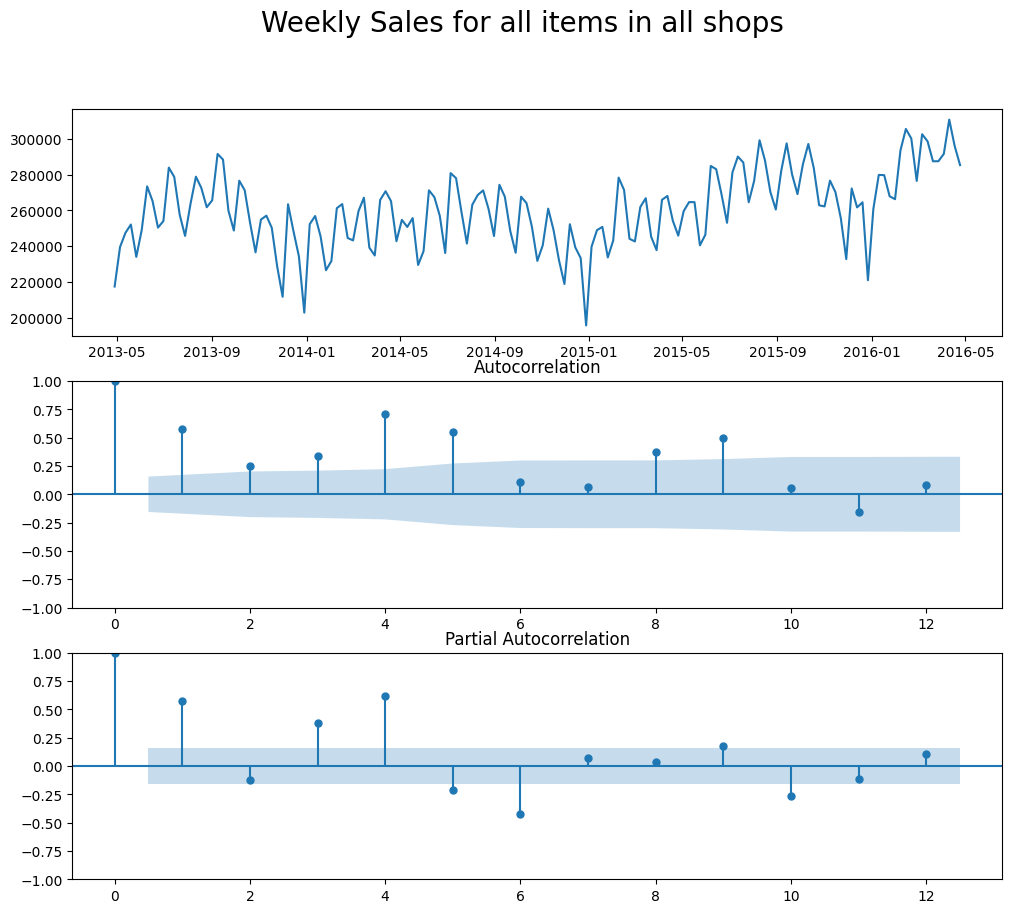

In [14]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

## Global

In [15]:
dfho = dfof[dfof["yearweek"]<201617] # DataFrame con informacion historica
dffo = dfof[dfof["yearweek"]>201616] # DataFrame con semanas a predecir

idxf=dffo["yearweek"].unique().tolist() # Lista Semana-Año a predecir
dfho.sort_values(["id", "yearweek"], ascending = True, inplace = True)
dffo.sort_values(["id", "yearweek"], ascending = True, inplace = True)


## Proyeccion Region 0

In [16]:
region=0

In [17]:
# Filtra los datos del DataFrame 'dfho' para la región 0
dfhos = dfho[dfho["region"] == region]

# Elimina la columna 'region' del DataFrame
dfhos.drop(["region"], inplace=True, axis=1)

# Filtra los datos del DataFrame para para la región 0
dffos = dffo[dffo["region"] == region]

# Elimina la columna 'region' del DataFrame
dffos.drop(["region"], inplace=True, axis=1)

# Crea un DataFrame vacío para almacenar los resultados de la predicción
dff0 = pd.DataFrame(columns=dfof.columns)

# Crea un DataFrame vacío para almacenar los resultados de la validación
dfv0 = pd.DataFrame(columns=dfof.columns)

# Crea un DataFrame vacío para almacenar los resultados
res0 = pd.DataFrame(columns=["Importancia", "Train RMSE", "Validation RMSE", "category"])



In [18]:
y = dfhos.set_index('date').resample("W")["Cantidad"].sum()[:-4] # quitamos los registros de las ultimas 4 semanas

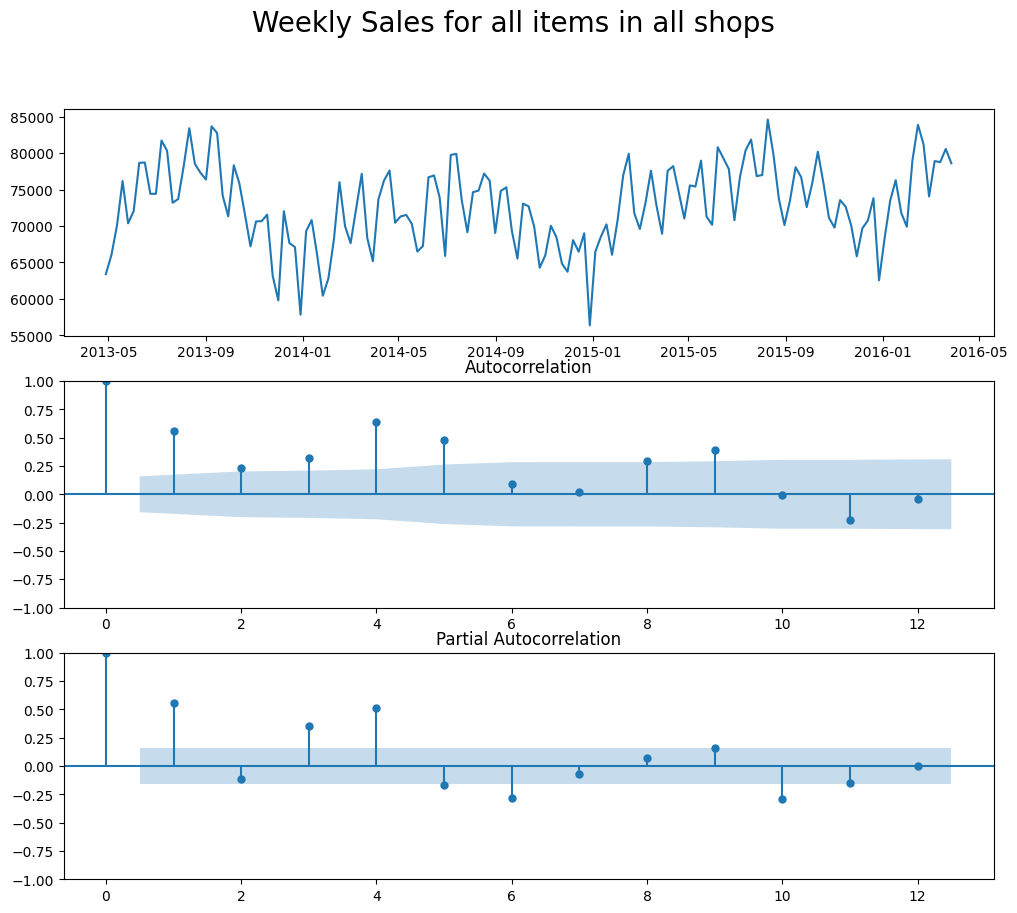

In [19]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

cat=  0
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6847
[LightGBM] [Info] Number of data points in the train set: 245107, number of used features: 40
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 4.043675
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[763]	valid_0's rmse: 3.90034
cat=  1
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing row-wise multi-th

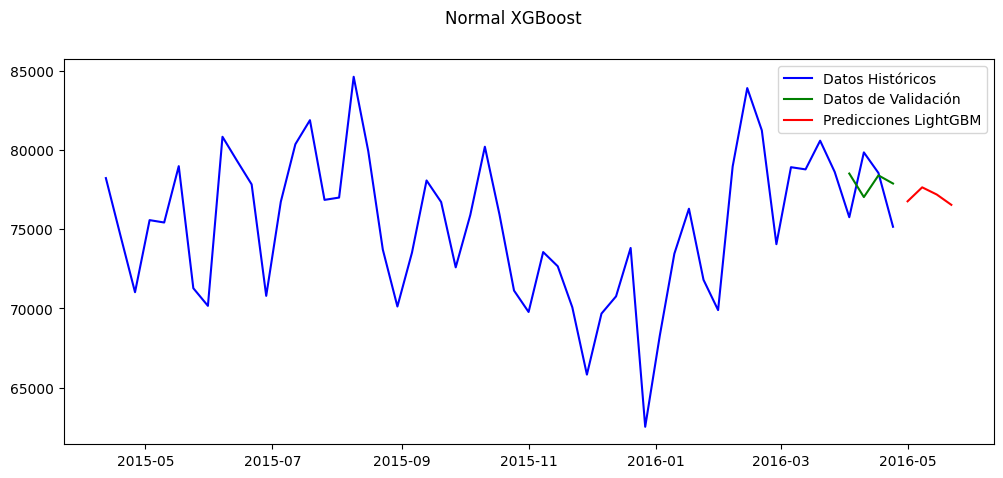

In [20]:
# Iterar sobre cada categoría única
for cat in dfo["category"].unique().tolist():
    print("cat= ", cat)  # Imprimir la categoría actual
    
    # Filtrar DataFrame para que solo contenga filas de la categoría actual
    dfhoc = dfhos[dfhos["category"] == cat]
    
    # Eliminar la columna 'category' del DataFrame
    dfhoc.drop(["category"], inplace=True, axis=1)
    
    # Filtrar DataFrame para que solo contenga filas de la categoría actual
    dffoc = dffos[dffos["category"] == cat]
    
    # Eliminar la columna 'category' del DataFrame
    dffoc.drop(["category"], inplace=True, axis=1)
    
    # Obtener predicciones a varios pasos adelante
    dfhoc, dfvv, res, col = get_n_step_prediction(dfh=dfhoc, idxf=idxf, dffo=dffoc, dfo=dfo, verbose=VERBOSE)
    
    # Añadir la categoría actual a los DataFrames resultantes
    dfvv["category"] = cat
    dfhoc["category"] = cat
    res["category"] = cat
    
    # Reindexar para que coincida con las columnas de 'dfo'
    dfhoc = dfhoc.reindex(columns=dfo.columns)
    
    # Concatenar los DataFrames resultantes con los DataFrames acumulativos
    dff0 = pd.concat([dff0, dfhoc])
    dfv0 = pd.concat([dfv0, dfvv])
    res0 = pd.concat([res0, res])

# Añadir la región a los DataFrames acumulativos
dff0["region"] = region
dfv0["region"] = region
res0["region"] = region

# Graficar las predicciones
plot_predictions(dfho=dff0, dffo=dfv0)


In [21]:
dfhoc=dfhos[dfhos["category"]==2]
dfhoc.drop(["category"], inplace = True, axis = 1)

In [22]:
y = dfhoc.set_index('date').resample("W")["Cantidad"].sum()[:-4] # quitamos los registros de las ultimas 4 semanas

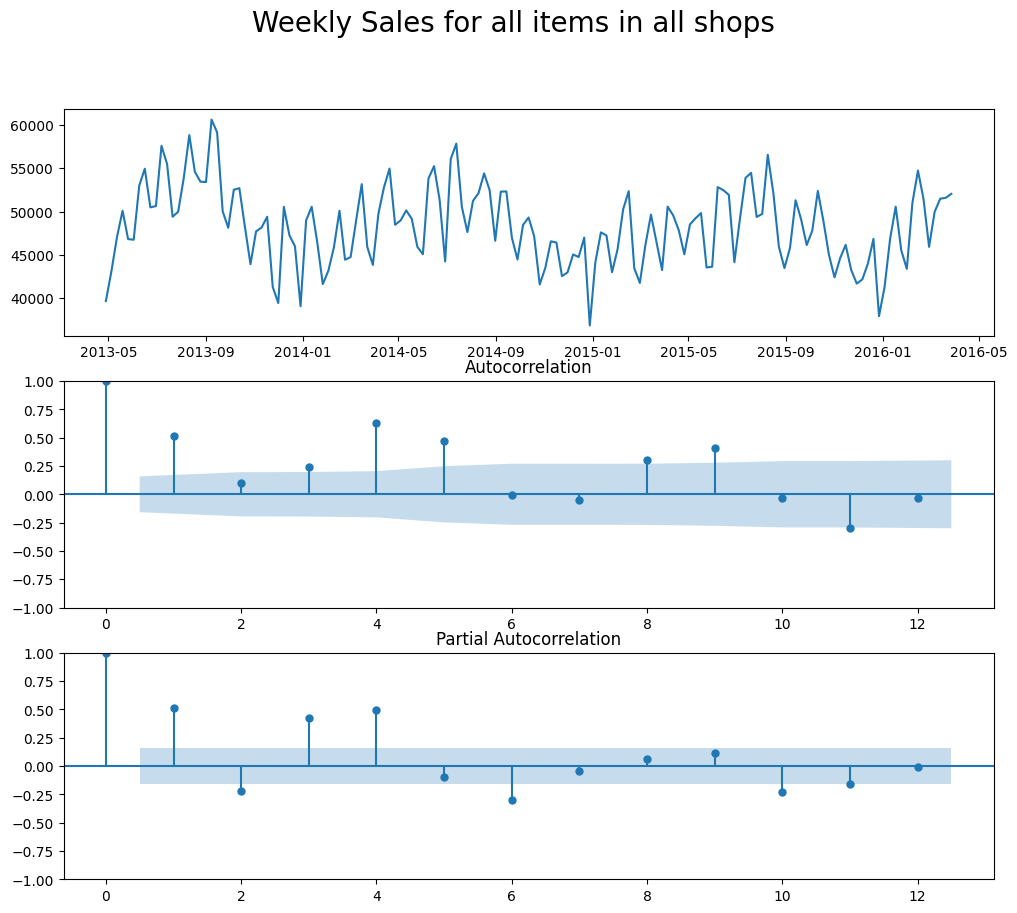

In [23]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

## Proyeccion Region 1

In [24]:
region=1

In [25]:
# Filtra los datos del DataFrame 'dfho' para la región 1
dfhos = dfho[dfho["region"] == region]

# Elimina la columna 'region' del DataFrame
dfhos.drop(["region"], inplace=True, axis=1)

# Filtra los datos del DataFrame para para la región 1
dffos = dffo[dffo["region"] == region]

# Elimina la columna 'region' del DataFrame
dffos.drop(["region"], inplace=True, axis=1)

# Crea un DataFrame vacío para almacenar los resultados de la predicción
dff1 = pd.DataFrame(columns=dfof.columns)

# Crea un DataFrame vacío para almacenar los resultados de la validación

dfv1 = pd.DataFrame(columns=dfof.columns)

# Crea un DataFrame vacío para almacenar los resultados
res1 = pd.DataFrame(columns=["Importancia", "Train RMSE", "Validation RMSE", "category"])


In [26]:
y = dfhos.set_index('date').resample("W")["Cantidad"].sum()[:-4] # quitamos los registros de las ultimas 4 semanas

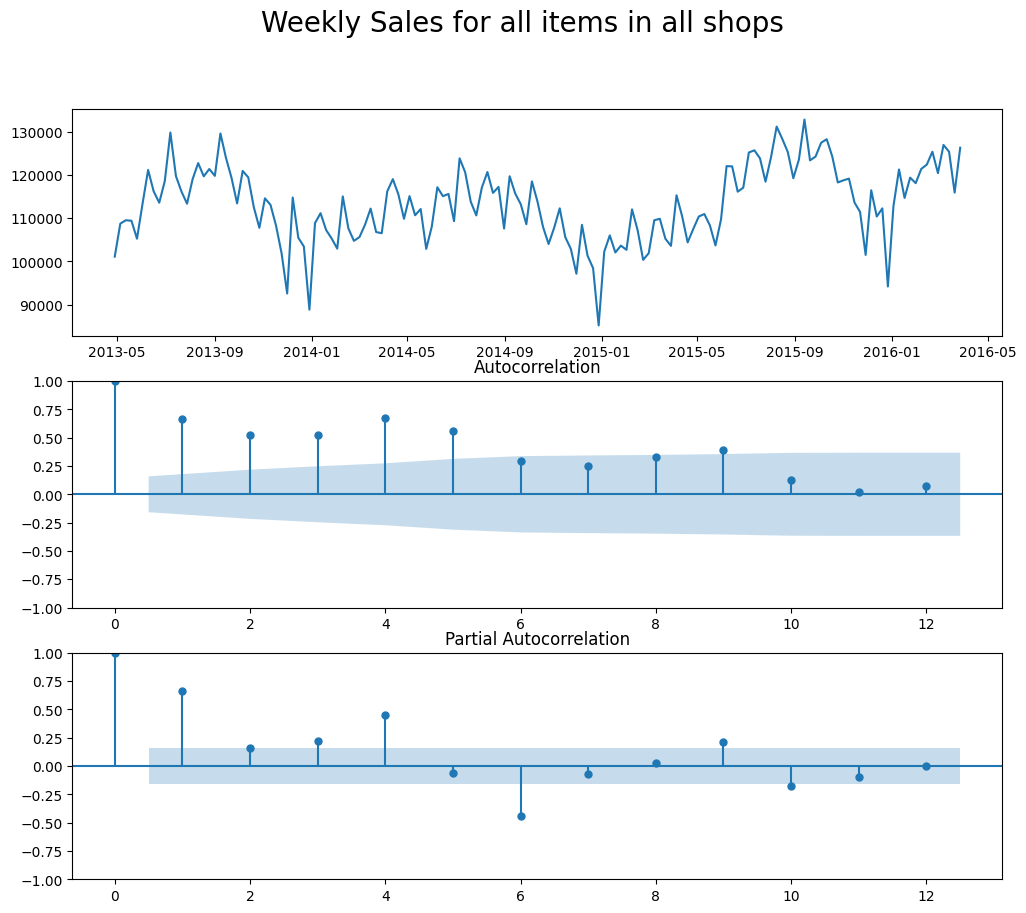

In [27]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

cat=  0
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7392
[LightGBM] [Info] Number of data points in the train set: 324956, number of used features: 40
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 5.793741
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[735]	valid_0's rmse: 5.09079
cat=  1
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-th

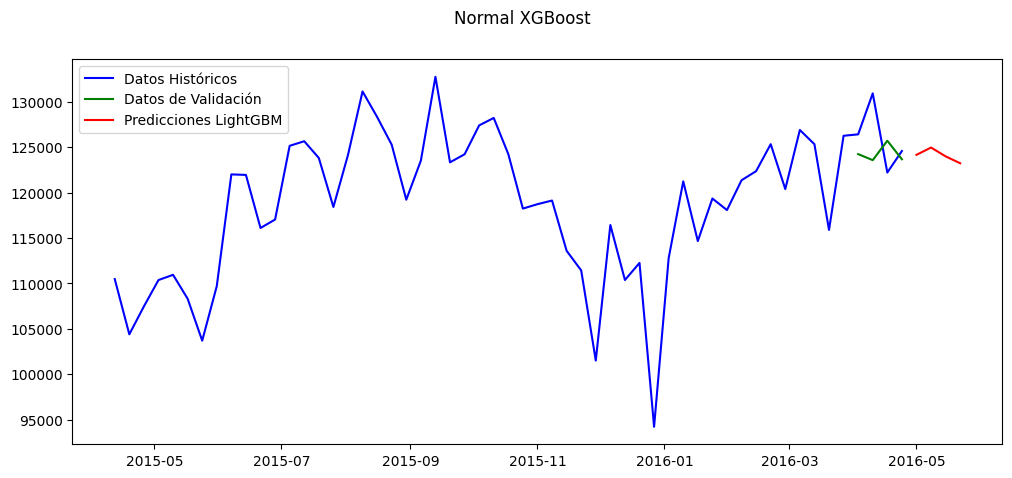

In [28]:
# Iterar sobre cada categoría única
for cat in dfo["category"].unique().tolist():
    print("cat= ", cat)  # Imprimir la categoría actual
    
    # Filtrar DataFrame para que solo contenga filas de la categoría actual
    dfhoc = dfhos[dfhos["category"] == cat]
    
    # Eliminar la columna 'category' del DataFrame
    dfhoc.drop(["category"], inplace=True, axis=1)
    
    # Filtrar DataFrame para que solo contenga filas de la categoría actual
    dffoc = dffos[dffos["category"] == cat]
    
    # Eliminar la columna 'category' del DataFrame
    dffoc.drop(["category"], inplace=True, axis=1)
    
    # Obtener predicciones a varios pasos adelante
    dfhoc, dfvv, res,col = get_n_step_prediction(dfh=dfhoc, idxf=idxf, dffo=dffoc, dfo=dfo, verbose=VERBOSE)
    
    # Añadir la categoría actual a los DataFrames resultantes
    dfvv["category"] = cat
    dfhoc["category"] = cat
    res["category"] = cat
    
    # Reindexar para que coincida con las columnas de 'dfo'
    dfhoc = dfhoc.reindex(columns=dfo.columns)
    
    # Concatenar los DataFrames resultantes con los DataFrames acumulativos
    dff1 = pd.concat([dff1, dfhoc])
    dfv1 = pd.concat([dfv1, dfvv])
    res1 = pd.concat([res1, res])

# Añadir la región a los DataFrames acumulativos
dff1["region"] = region
dfv1["region"] = region
res1["region"] = region

# Graficar las predicciones
plot_predictions(dfho=dff1, dffo=dfv1)


## Proyeccion Region 2

In [29]:
region=2

In [30]:
# Filtra los datos del DataFrame 'dfho' para la región 0
dfhos = dfho[dfho["region"] == region]

# Elimina la columna 'region' del DataFrame
dfhos.drop(["region"], inplace=True, axis=1)  # Eliminar la columna 'region' del DataFrame 'dfhos'

# Filtra los datos del DataFrame para para la región 0
dffos = dffo[dffo["region"] == region]

# Elimina la columna 'region' del DataFrame
dffos.drop(["region"], inplace=True, axis=1)  # Eliminar la columna 'region' del DataFrame 'dffos'

# Crea un DataFrame vacío para almacenar los resultados de la predicción
dff2 = pd.DataFrame(columns=dfof.columns)

# Crea un DataFrame vacío para almacenar los resultados de la validación
dfv2 = pd.DataFrame(columns=dfof.columns)

# Crea un DataFrame vacío para almacenar los resultados
res2 = pd.DataFrame(columns=["Importancia", "Train RMSE", "Validation RMSE", "category"])


In [31]:
y = dfhos.set_index('date').resample("W")["Cantidad"].sum()[:-4] # quitamos los registros de las ultimas 4 semanas

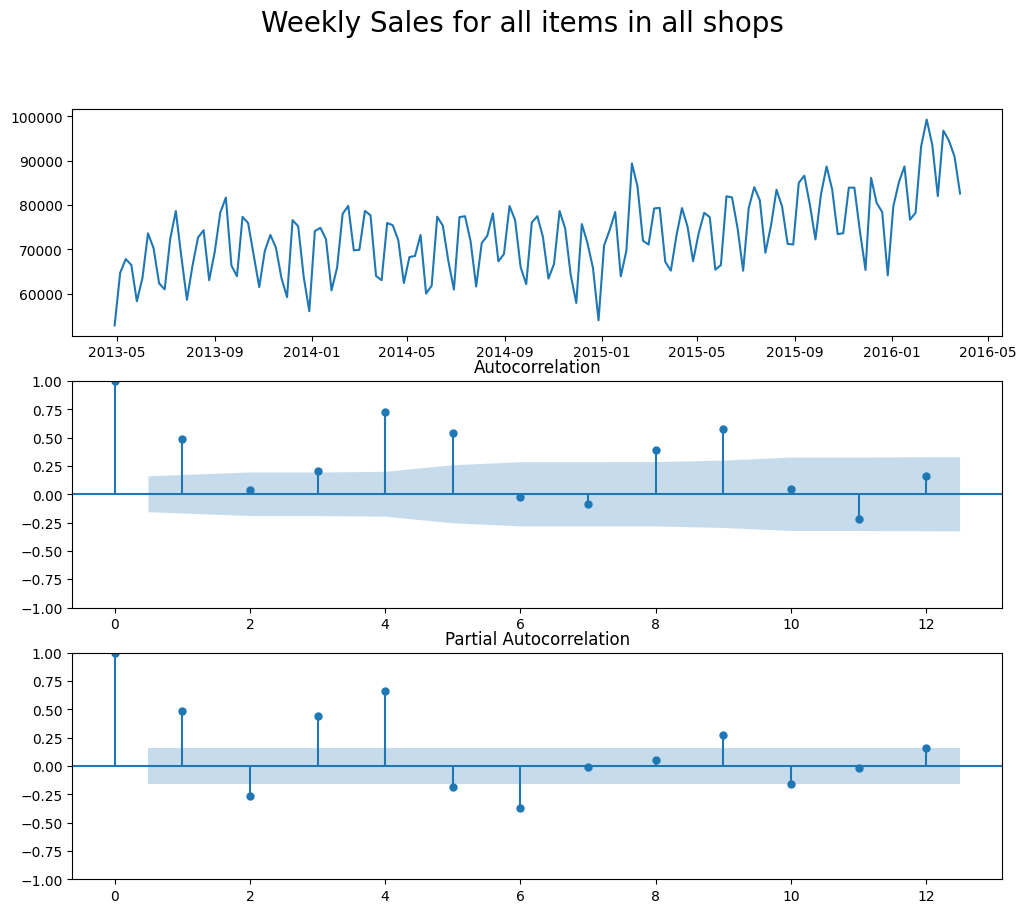

In [32]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

cat=  0
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6579
[LightGBM] [Info] Number of data points in the train set: 245767, number of used features: 40
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 3.654742
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 3.75395
cat=  1
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020232 secon

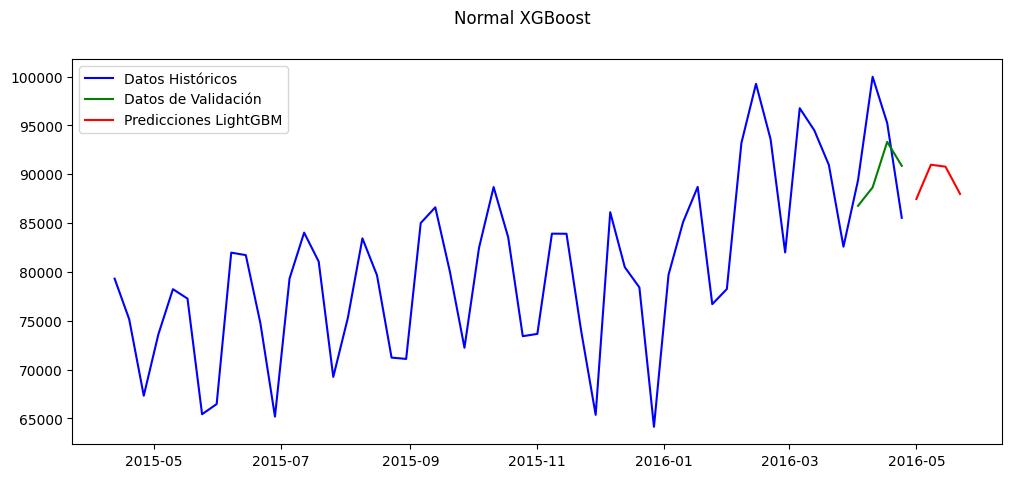

In [33]:
# Iterar sobre cada categoría única
for cat in dfo["category"].unique().tolist():
    print("cat= ", cat)  # Imprimir la categoría actual
    
    # Filtrar DataFrame para que solo contenga filas de la categoría actual
    dfhoc = dfhos[dfhos["category"] == cat]

    # Eliminar la columna 'category' del DataFrame
    dfhoc.drop(["category"], inplace=True, axis=1)  # Eliminar la columna 'category' del DataFrame 'dfhoc'
    
    # Filtrar DataFrame para que solo contenga filas de la categoría actual
    dffoc = dffos[dffos["category"] == cat]

    # Eliminar la columna 'category' del DataFrame
    dffoc.drop(["category"], inplace=True, axis=1)  # Eliminar la columna 'category' del DataFrame 'dffoc'
    
    # Obtener predicciones a varios pasos adelante
    dfhoc, dfvv, res, col = get_n_step_prediction(dfh=dfhoc, idxf=idxf, dffo=dffoc, dfo=dfo, verbose=VERBOSE)
    
    # Añadir la categoría actual a los DataFrames resultantes
    dfvv["category"] = cat
    dfhoc["category"] = cat
    res["category"] = cat
    
    # Reindexar para que coincida con las columnas de 'dfo'
    dfhoc = dfhoc.reindex(columns=dfo.columns)
    
    # Concatenar los DataFrames resultantes con los DataFrames acumulativos
    dff2 = pd.concat([dff2, dfhoc])
    dfv2 = pd.concat([dfv2, dfvv])
    res2 = pd.concat([res2, res])

# Añadir la región a los DataFrames acumulativos
dff2["region"] = region
dfv2["region"] = region
res2["region"] = region

# Graficar las predicciones
plot_predictions(dfho=dff2, dffo=dfv2)


# Consolidar Resultados

In [34]:
resultado=pd.concat([res0,res1,res2])

In [35]:
resultado

,Importancia,Train RMSE,Validation RMSE,category,region
0,"[792, 3, 188, 1136, 1649, 16, 175, 0, 0, 456, ...",3_959,3_9,0,0
0,"[386, 157, 24, 714, 778, 25, 173, 0, 0, 553, 2...",5_457,4_707,1,0
0,"[369, 0, 92, 423, 1706, 291, 380, 0, 0, 998, 4...",11_06,7_099,2,0
0,"[648, 1, 432, 1960, 1293, 35, 82, 0, 0, 871, 2...",5_265,5_091,0,1
0,"[555, 225, 816, 1688, 1188, 153, 497, 0, 0, 20...",5_087,5_121,1,1
0,"[438, 0, 102, 601, 1155, 36, 198, 0, 0, 863, 4...",12_781,8_524,2,1
0,"[923, 110, 831, 1774, 1889, 78, 321, 0, 0, 101...",3_452,3_754,0,2
0,"[246, 170, 133, 1210, 774, 327, 656, 0, 0, 199...",4_447,4_664,1,2
0,"[430, 0, 108, 977, 1290, 104, 275, 0, 0, 1422,...",11_998,11_692,2,2


## Importancia de Variables

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Boston , Categoria: Accesorios')

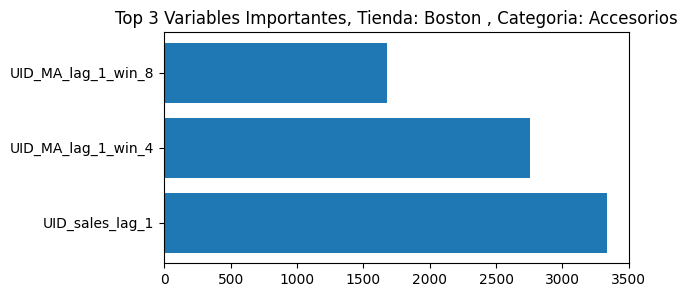

In [71]:
feature_importance = resultado.iat[0,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Boston , Categoria: Accesorios")

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Nueva York , Categoria: Accesorios')

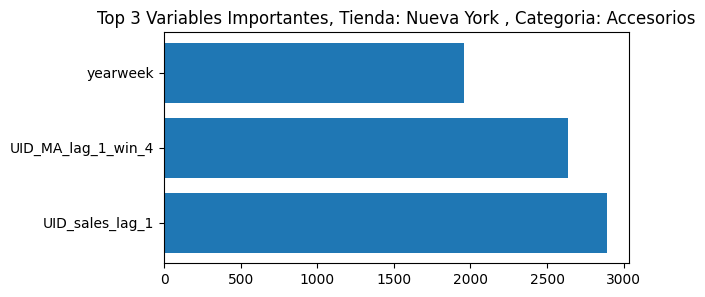

In [77]:
feature_importance = resultado.iat[3,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Nueva York , Categoria: Accesorios")

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Philadelphia , Categoria: Accesorios')

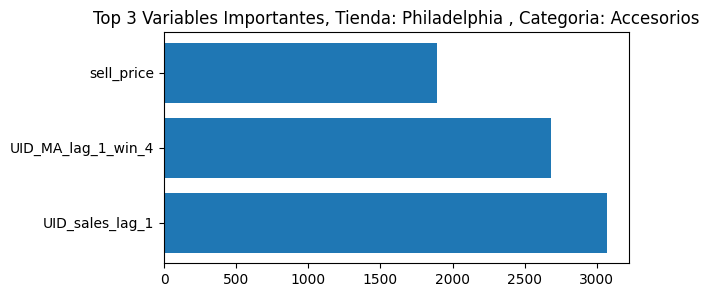

In [74]:
feature_importance = resultado.iat[6,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Philadelphia , Categoria: Accesorios")

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Boston , Categoria: Home & Garden')

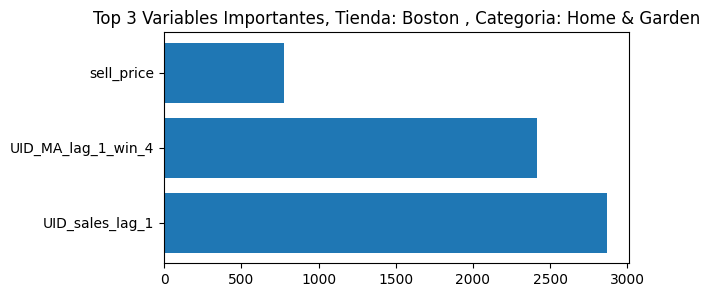

In [79]:
feature_importance = resultado.iat[1,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Boston , Categoria: Home & Garden")

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Nueva York , Categoria: Home & Garden')

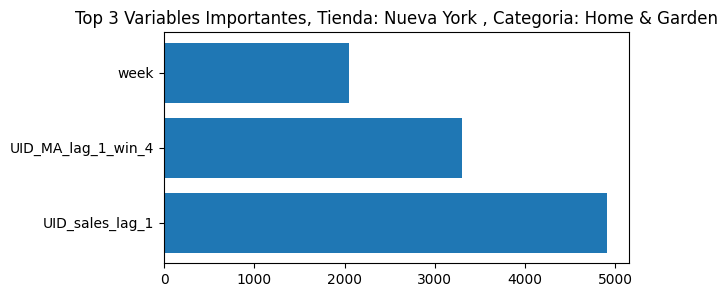

In [76]:
feature_importance = resultado.iat[4,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Nueva York , Categoria: Home & Garden")

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Philadelphia , Categoria: Home & Garden')

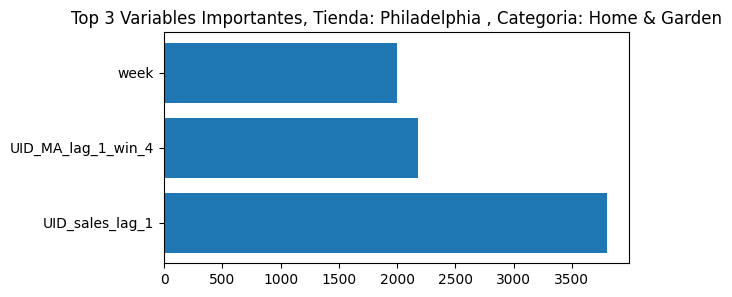

In [73]:
feature_importance = resultado.iat[7,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Philadelphia , Categoria: Home & Garden")

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Boston , Categoria: Supermercado')

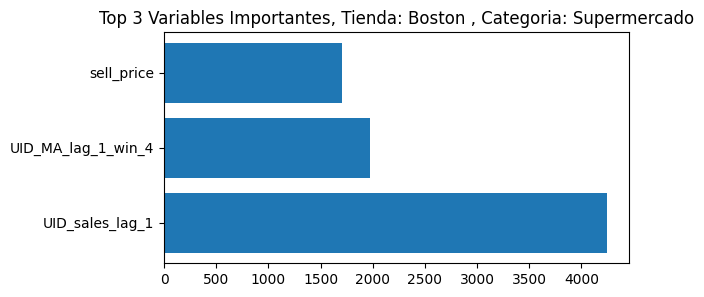

In [78]:
feature_importance = resultado.iat[2,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Boston , Categoria: Supermercado")

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Nueva York , Categoria: Supermercado')

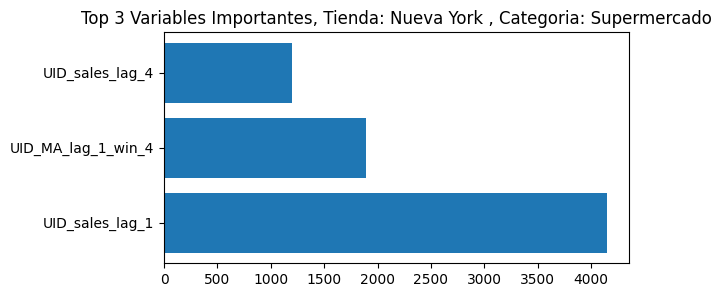

In [75]:
feature_importance = resultado.iat[5,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Nueva York , Categoria: Supermercado")

Text(0.5, 1.0, 'Top 3 Variables Importantes, Tienda: Philadelphia , Categoria: Supermercado')

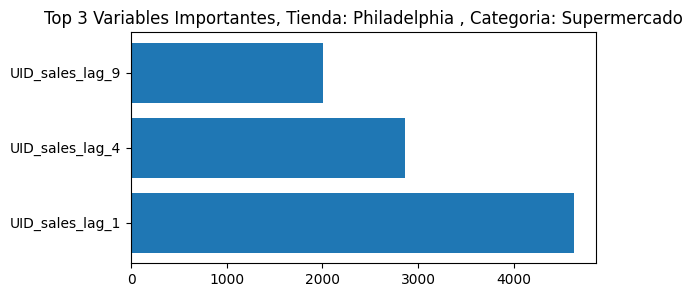

In [72]:
feature_importance = resultado.iat[8,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:3]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(6, 3))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 3 Variables Importantes, Tienda: Philadelphia , Categoria: Supermercado")

In [37]:
dfv=pd.concat([dfv0,dfv1,dfv2])

In [38]:
dff=pd.concat([dff0,dff1,dff2])

In [39]:
dff["Cantidad"].min()

0.0

In [40]:
y = dfv.set_index('date').resample("W")["Cantidad"].sum() # quitamos los registros de las ultimas 4 semanas

In [41]:
y

date
2016-04-03    289523.508604
2016-04-10    289260.562098
2016-04-17    297431.552689
2016-04-24    292418.834212
Freq: W-SUN, Name: Cantidad, dtype: float64

In [42]:
y = dff.set_index('date').resample("W")["Cantidad"].sum() # quitamos los registros de las ultimas 4 semanas

In [43]:
y[-8:-4]

date
2016-04-03    291571.0
2016-04-10    310767.0
2016-04-17    296009.0
2016-04-24    285279.0
Freq: W-SUN, Name: Cantidad, dtype: float64

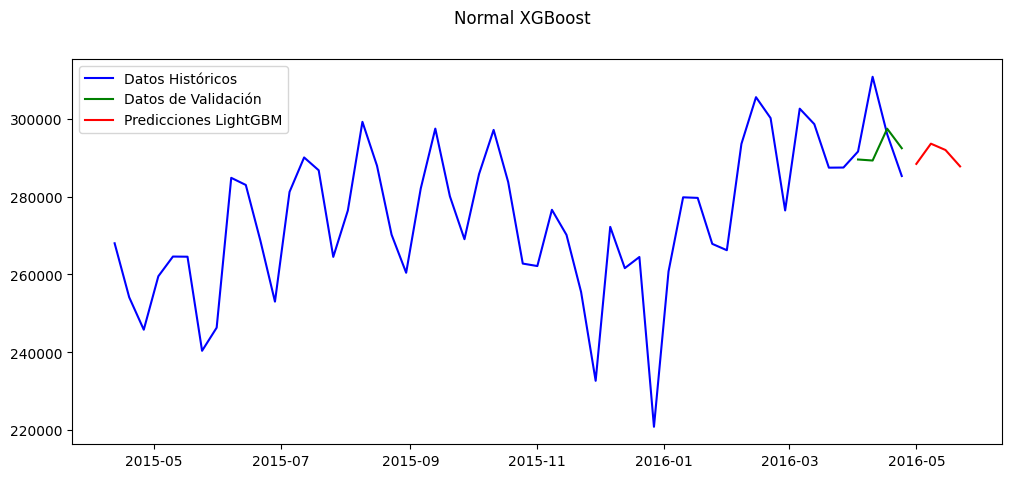

In [44]:
plot_predictions(dfho =dff, dffo = dfv)

In [45]:
dfv=dfv.rename(columns={"Cantidad":"Valid"})

In [46]:
dff=pd.merge(dff,dfv[["id","yearweek","Valid"]],how="left",on=["id","yearweek"]) # llevamos los datos de validación al DataFrame

In [47]:
# Calculamos el RMSE Global de validación

Y_valid_total=dff[(dff["yearweek"]>201612)&(dff["yearweek"]<201617)]["Cantidad"]
Y_valid_pred=dff[(dff["yearweek"]>201612)&(dff["yearweek"]<201617)]["Valid"]

rmse_valida = np.sqrt(
                                mean_squared_error(
                                    y_true = Y_valid_total,
                                    y_pred = Y_valid_pred
                                )
                            )

In [48]:
rmse_valida

7.200155024881583

In [49]:
Y_valid_total.min()

0.0

In [50]:
Y_valid_pred.min()

0.3734958718004692

## Guardar archivos

In [ ]:
from pathlib import Path  
filepath = Path("data/pred.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
dff.to_csv(filepath,index=False)  

In [ ]:
from pathlib import Path  
filepath = Path("data/val.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
dfv.to_csv(filepath,index=False)  